# Tâche prédiction du sexe

## Consignes

Dans certains recensements, le sexe n’est pas renseigné. C’est pourtant une données nécessaire pour l’analyse des ménages et pour effectuer le suivi des individus entre les différents recensements.

Tache :
- mettre au point un système pour prédire le sexe d’un individu à partir de ses données personnelles
- évaluer le système
- analyser les conditions de son application à l’ensemble du corpus

Données disponibles :
- un fichier de prénoms avec la fréquence du sexe des personnes le portant : firstname_with_sex.csv
- un fichier contenant les transcriptions manuelle, transcription automatique et le sexe associé : transcriptions_with_sex.csv


## Méthode Proposée

1. **Prétraitement des données**:
    - Charger les données depuis les fichiers CSV.
    - Extraire les champs nécessaires tels que prénoms et le sexe.
    - Nettoyer et normaliser les prénoms (par exemple, mettre en minuscule, retirer les espaces excédentaires).

2. **Construction du modèle de prédiction**:
    - Utiliser un modèle de classification (comme une régression logistique) qui apprend à associer un prénom à un sexe basé sur les fréquences dans vos données.
    - Vous pouvez aussi essayer des modèles plus complexes si les performances ne sont pas satisfaisantes (par exemple, des réseaux de neurones ou des modèles basés sur des arbres de décision).

3. **Évaluation du modèle**:
    - Diviser les données en un ensemble d'entraînement et un ensemble de test.
    - Entraîner le modèle sur l'ensemble d'entraînement.
    - Évaluer la précision du modèle sur l'ensemble de test.

4. **Analyse d'application**:
    - Vérifier la performance du modèle sur des cas limites et diversifiés pour évaluer son application généralisée.
    - Analyser la distribution des erreurs pour identifier des biais potentiels.

## Code Python 

### Import données

In [10]:
import pandas as pd

# Charger les données
firstname_data = pd.read_csv('./data/firstname_with_sex.csv', sep=";")
transcriptions_data = pd.read_csv('./data/transcriptions_with_sex.csv',)

# Prétraitement : extraire prénoms et les normaliser (minuscule)
firstname_data['firstname'] = firstname_data['firstname'].str.lower().str.strip()
firstname_data.set_index("firstname", inplace=True)
transcriptions_data['firstname'] = transcriptions_data['prediction'].apply(lambda x: x.split('prénom:')[1].split(' ')[1].strip()).str.lower().str.strip()

# joins data
transcriptions_data = transcriptions_data.join(firstname_data, on="firstname",how="left", validate="many_to_one")

transcriptions_data["ratio_homme"] = transcriptions_data["male"] / (transcriptions_data["female"]+transcriptions_data["male"])

### Description des catégories de sexe

<Axes: xlabel='sex', ylabel='count'>

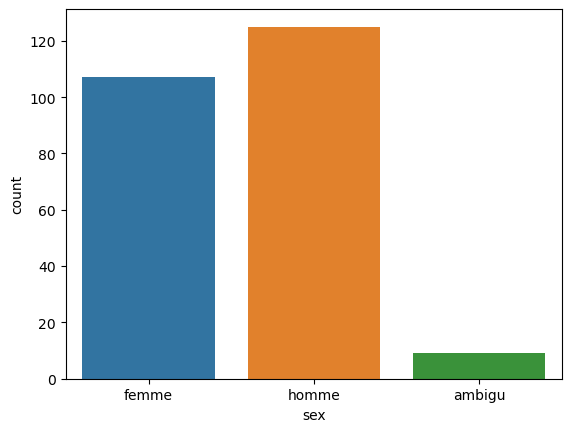

In [11]:
import seaborn as sns
%matplotlib inline

sns.countplot(transcriptions_data,x= 'sex')


In [12]:
pd.value_counts(transcriptions_data["sex"])

C:\Users\leopo\AppData\Local\Temp\ipykernel_20720\3398324066.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(transcriptions_data["sex"])


sex
homme     125
femme     107
ambigu      9
Name: count, dtype: int64

#### Nom les plus fréquents par catégorie de sexe

C:\Users\leopo\AppData\Local\Temp\ipykernel_20720\1343384465.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


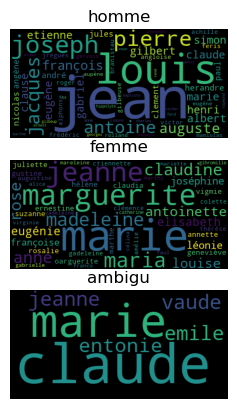

In [13]:
from wordcloud import WordCloud
# Display one wordcloud for each of the most frequent classes

from wordcloud import WordCloud
STOPWORDS = [x.strip() for x in open('data/stop_words.txt').readlines()]
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3)

transcriptions_data['firstname'].str.cat(sep=' ')

# plot a word cloud for each category
for i,cat in enumerate(['homme', 'femme',  'ambigu']):
    total_text = transcriptions_data[transcriptions_data["sex"]==cat].firstname.str.cat(sep=' ')

    wc = WordCloud(stopwords = STOPWORDS).generate(total_text)
    
    axs[i].imshow(wc)
    axs[i].axis('off')
    axs[i].set_title(cat)

fig.show()

#### Description informations recensements du OCR

C:\Users\leopo\AppData\Local\Temp\ipykernel_20720\387489299.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


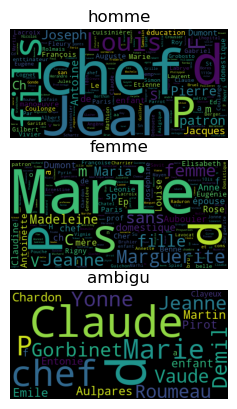

In [14]:
from wordcloud import WordCloud
# Display one wordcloud for each of the most frequent classes

from wordcloud import WordCloud
# les stop words inclut les catégorie du recensement comme lieux_naissance, nom, prénom
STOPWORDS = [x.strip() for x in open('data/stop_words.txt').readlines()]
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3)

transcriptions_data['prediction'].str.cat(sep=' ')

# plot a word cloud for each category
for i,cat in enumerate(['homme', 'femme',  'ambigu']):
    total_text = transcriptions_data[transcriptions_data["sex"]==cat].prediction.str.cat(sep=' ')

    wc = WordCloud(stopwords = STOPWORDS).generate(total_text)
    
    axs[i].imshow(wc)
    axs[i].axis('off')
    axs[i].set_title(cat)

fig.show()

On voit que au delà des prénoms genrés par catégorie, on trouve des mots clés comme chef pour les hommes ou femme pour les femmes.
On peut espérer qu'un modèle qui combine les informations de fréquence genrée de prénoms et les mots clés présents dans le recensements (soit avec un modèle simple avec une matrice de fréquence, soit avec un modèle zero shot) arrive à prédire le sexe.

#### Catégorie ambigu

In [15]:
pd.set_option('display.max_colwidth', None)

transcriptions_data[transcriptions_data["sex"]=='ambigu']

,subject_line,groundtruth,prediction,sex,firstname,male,female,ratio_homme
17,421b3e1f-ff91-4871-a8de-3af62c58e3bc,surname: Daniel firstname: Claude occupation: journalier link: chef age: 33,nom: Demil prénom: Claude date_naissance: 33 lieux_naissance: Yonne relation: chef,ambigu,claude,324134.0,4830.0,0.985318
59,8339da37-3493-4684-a9fd-090411f33d01,surname: Gorbinet firstname: Jeanne occupation: idem link: chef age: 66,nom: Gorbinet prénom: Jeanne date_naissance: 66 lieux_naissance: id relation: id,ambigu,jeanne,1765.0,1097397.0,0.001606
94,e1e6fb82-6417-4dcf-8eaa-7d5a5e9f6551,surname: Roumeau firstname: Claude occupation: cultivateur link: chef age: 30 ans,nom: Roumeau prénom: Vaude date_naissance: 1804 lieux_naissance: Aulpares relation: Chef,ambigu,vaude,NaN,NaN,NaN
123,e6927138-689e-4d70-89c2-cf86f7171fd1,surname: Chardon firstname: Marie occupation: idem link: chef age: 84 ans,"nom: Chardon prénom: Marie date_naissance: 84 lieux_naissance: "" relation: D",ambigu,marie,10145.0,2390322.0,0.004226
124,5b244d56-e1da-4b57-934a-0a1234f34709,surname: Grillé firstname: Emile occupation: idem link: idem employer: idem age: 2,"nom: d prénom: Emile date_naissance: 2 lieux_naissance: d relation: "" profession: """,ambigu,emile,65749.0,444.0,0.993292
130,623f7836-8a46-4078-914e-f3cb9bb51c6e,surname: Martin firstname: Marie occupation: idem link: idem age: 45,nom: Martin prénom: Marie date_naissance: 47 lieux_naissance: P id état_civil: id profession: id,ambigu,marie,10145.0,2390322.0,0.004226
196,91b1d765-2195-462d-a85b-72233327ff4d,surname: Pénot firstname: Claude occupation: s.p link: enfant age: 13,nom: Pirot prénom: Claude date_naissance: 1303 lieux_naissance: id relation: enfant,ambigu,claude,324134.0,4830.0,0.985318
204,a17f5fb3-c879-4a9a-a063-e3a43f4f4a3c,surname: Coq firstname: Antonie occupation: idem link: idem employer: idem age: 16,nom: d prénom: Entonie date_naissance: 16 lieux_naissance: d relation: f,ambigu,entonie,NaN,NaN,NaN
230,e925d46e-1ea7-4537-986e-0fe062d64fa2,surname: Clayeux firstname: Claude occupation: idem link: idem employer: idem age: 13,nom: Clayeux prénom: Claude date_naissance: 13 lieux_naissance: P relation: a,ambigu,claude,324134.0,4830.0,0.985318


Il me semble qu'on peut filtrer les données dont on n'a pas l'information de sexe ni grâce aux informations de recensements ni grâce aux à la fréquence genrée d'apparition du prénom. C'est le cas pour vaude et entonie dont le sexe a été marqué comme ambigu.

Pour les autres personnes dont les informations de recensements n'ont pas permi de déterminer le sexe, en regardant la fréquence d'apparition dans la population générale du prénom, il semble y avoir une division claire avec des prénoms données à  plus de 98% à des hommes, et de prénoms données à 99% à des femmes.
On va donc reclassifier la catégorie 'ambigu' avec l'information de fréquence genrée du prénom, suivant un critère simple : si les informations sont ambigus et que le prénom est porté en majorité par des hommes, on réattribue le sexe à 'homme'.

On peut tenter un premier modèle avec simplement les informations du recensement avec une approche bag-of-words. On supprimera les mots des catégories du recensement.

In [16]:
correction_sex_ambigu = lambda x: 'homme' if x > 0.5 else 'femme'

transcriptions_data["sex_simple_criteria"] = transcriptions_data["ratio_homme"].apply(correction_sex_ambigu)

transcriptions_data[transcriptions_data["sex_simple_criteria"]!=transcriptions_data["sex"]]["sex"].value_counts()

sex
homme     24
ambigu     9
Name: count, dtype: int64

## Préparation des données

In [17]:
from sklearn.model_selection import train_test_split

seed = 42

correction_sex_ambigu = lambda x: 'homme' if x > 0.5 else 'femme'

# filtre out les données trop ambigu (en fréquence et en recensement) pour le modèle
predictable_data = transcriptions_data[~((transcriptions_data["ratio_homme"].isna()) & (transcriptions_data["sex"] == 'ambigu'))]
predictable_data.set_index("subject_line", inplace=True)
# reclassification du sexe des catégories ambigu avec une information de fréquence
predictable_data.loc[predictable_data["sex"] == 'ambigu', "sex"] = predictable_data.loc[predictable_data["sex"] == 'ambigu', "ratio_homme"].apply(correction_sex_ambigu)

# clean le texte des catégories pour ne pas biaiser les fréquences
STOPWORDS = [x.strip() for x in open('./data/stop_words.txt').readlines()]

X = predictable_data[["prediction","ratio_homme"]].rename(columns={
    'prediction':'text',
    'ratio_homme':'ratio'
})

Y = predictable_data.sex

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify=Y)

# on met le texte en bag of words : count vectors et TfIdf
# pour l'instant pas de filtre sur les mots.
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Create document vectors
vectorizer = CountVectorizer(max_features=1000, stop_words=STOPWORDS)
vectorizer.fit(X_train.text)

X_train.text_count = vectorizer.transform(X_train.text)
X_test.text_count = vectorizer.transform(X_test.text)

tf_transformer = TfidfTransformer().fit(X_train.text_count)
X_train.text_tf = tf_transformer.transform(X_train.text_count)
X_test.text_tf = tf_transformer.transform(X_test.text_count)

C:\Users\leopo\AppData\Local\Temp\ipykernel_20720\1866252429.py:32: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_train.text_count = vectorizer.transform(X_train.text)
C:\Users\leopo\AppData\Local\Temp\ipykernel_20720\1866252429.py:33: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_test.text_count = vectorizer.transform(X_test.text)
C:\Users\leopo\AppData\Local\Temp\ipykernel_20720\1866252429.py:36: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_train.text_tf = tf_transformer.transform(X_train.text_count)
C:\Users\leopo\AppData\Local\Temp\ipykernel_20720\1866252429.py:37: UserWarning: Pandas doesn't allow columns to be created via 

## Modèle bag of words

### Avec Tf-Idf

In [19]:
from sklearn.naive_bayes import MultinomialNB
# train a Naive Bayes classifier
# create the MultinomialNB
model = MultinomialNB()
# Train 
model.fit(X_train.text_tf,Y_train) 
# Predict
Y_pred = model.predict(X_test.text_tf)
# Evaluate 
model.score(X_test.text_tf,Y_test)

0.8958333333333334

### Avec le simple count

In [20]:
from sklearn.naive_bayes import MultinomialNB
# train a Naive Bayes classifier
# create the MultinomialNB
model = MultinomialNB()
# Train 
model.fit(X_train.text_count,Y_train) 
# Predict
Y_pred = model.predict(X_test.text_count)
# Evaluate 
model.score(X_test.text_count,Y_test)

0.9166666666666666

### Estimation de la qualité du modèle

Classification Report:
               precision    recall  f1-score   support

       femme       0.91      0.91      0.91        22
       homme       0.92      0.92      0.92        26

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48



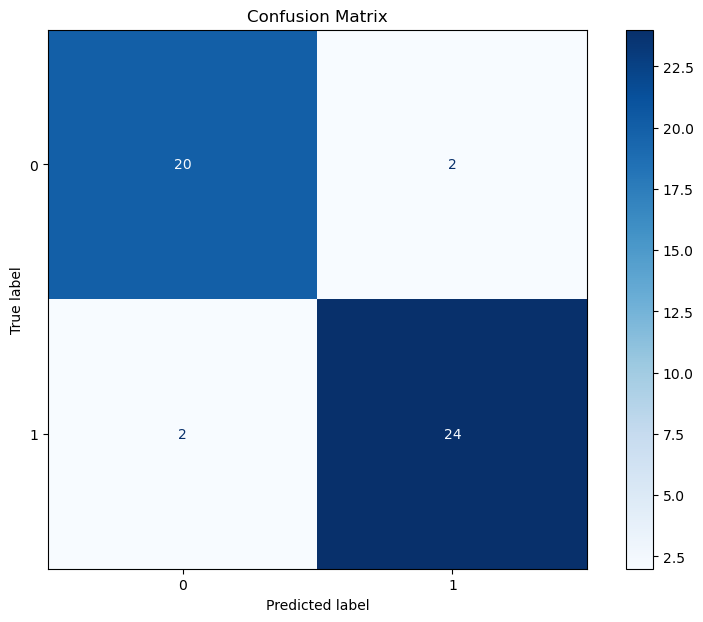

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Assuming model is your trained MultinomialNB classifier
# And X_test_tf, Y_test are your test features and labels

# Generate the classification report
report = classification_report(Y_test, Y_pred, zero_division = 0)
print("Classification Report:\n", report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
#print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

### Cas des mal classifiés

In [22]:
import numpy as np
miss_prediction_lines = np.array(Y_test[(Y_pred!=Y_test)].index)
transcriptions_data[transcriptions_data["subject_line"].isin(miss_prediction_lines)]

,subject_line,groundtruth,prediction,sex,firstname,male,female,ratio_homme,sex_simple_criteria
55,d2a70691-810f-4d22-903b-04afe1d02b58,surname: Richard firstname: Justine occupation: s.p. link: femme age: 33,nom: Michard prénom: Gustine date_naissance: 33 lieux_naissance: Yomne état_civil: s p,femme,gustine,1.0,240.0,0.004149,femme
60,9f854b01-5871-4d09-8bcc-af06f5f20374,surname: Grette firstname: Clément occupation: domestique de ferme age: 15,nom: Prette prénom: Clement date_naissance: 15 lieux_naissance: d profession: Domestique de ferma,homme,clement,1505.0,12.0,0.992090,homme
219,5849620a-6651-4bc5-83d9-4e701130e5dc,surname: Souche firstname: France occupation: idem link: idem age: 2,nom: Soziche prénom: Franco date_naissance: 2 lieux_naissance: id profession: id,femme,franco,NaN,NaN,NaN,femme
228,5ebc6baa-2929-483a-95a0-59408e496cb1,surname: Carton firstname: Simon occupation: cultivateur link: fils age: 30,nom: Carton prénom: Simone date_naissance: 30 lieux_naissance: ed profession: Cubsinière,homme,simone,157.0,6988.0,0.021973,femme


On voit qu'avec un simple critère sur la fréquence du prénom, on pourrait bien classifier deux personnes (gustine etc clément) qui ne sont pas bien classifier avec seulement leurs informations de recensement. Il faut donc ajouter les informations de fréquence au modèle.

## Bag-of-words + fréquence

In [27]:
from scipy.sparse import hstack
X_train.combined_features = hstack([X_train.text_count, np.array(X_train['ratio']).reshape(-1,1)])
X_train.combined_features = np.nan_to_num(X_train.combined_features, nan=0.5)
X_test.combined_features = hstack([X_test.text_count, np.array(X_test['ratio']).reshape(-1,1)])
X_test.combined_features = np.nan_to_num(X_test.combined_features, nan=0.5)


C:\Users\leopo\AppData\Local\Temp\ipykernel_20720\3604655418.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  X_test.combined_features = hstack([X_test.text_count, np.array(X_test['ratio']).reshape(-1,1)])


### Modèle avec combined_features

In [28]:
from sklearn.naive_bayes import MultinomialNB
# train a Naive Bayes classifier
# create the MultinomialNB
model = MultinomialNB()
# Train 
model.fit(X_train.combined_features,Y_train) 
# Predict
Y_pred = model.predict(X_test.combined_features)
# Evaluate 
model.score(X_test.combined_features,Y_test)

ValueError: Input X contains NaN.
MultinomialNB does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Estimation de la qualité du modèle

Classification Report:
               precision    recall  f1-score   support

       femme       0.91      0.91      0.91        22
       homme       0.92      0.92      0.92        26

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48



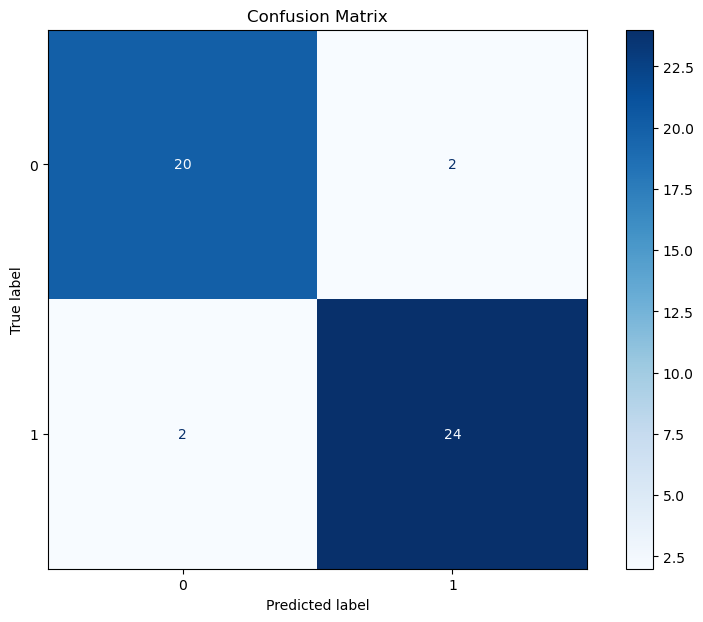

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Assuming model is your trained MultinomialNB classifier
# And X_test_tf, Y_test are your test features and labels

# Generate the classification report
report = classification_report(Y_test, Y_pred, zero_division = 0)
print("Classification Report:\n", report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
#print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()